YEAR:  2007
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   

           adresse     nom               maj  valeur  
0  ROUTE NATIONALE  Gazole  2007_01_04_18:43   999.0  
1  ROUTE NATIONALE  Gazole  2007_01_09_08:32   999.0  
2  ROUTE NATIONALE  Gazole  2007_01_12_08:42   989.0  
3  ROUTE NATIONALE  Gazole  2007_01_16_16:18   988.0  
4  ROUTE NATIONALE  Gazole  2007_01_17_09:16   988.0  
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000

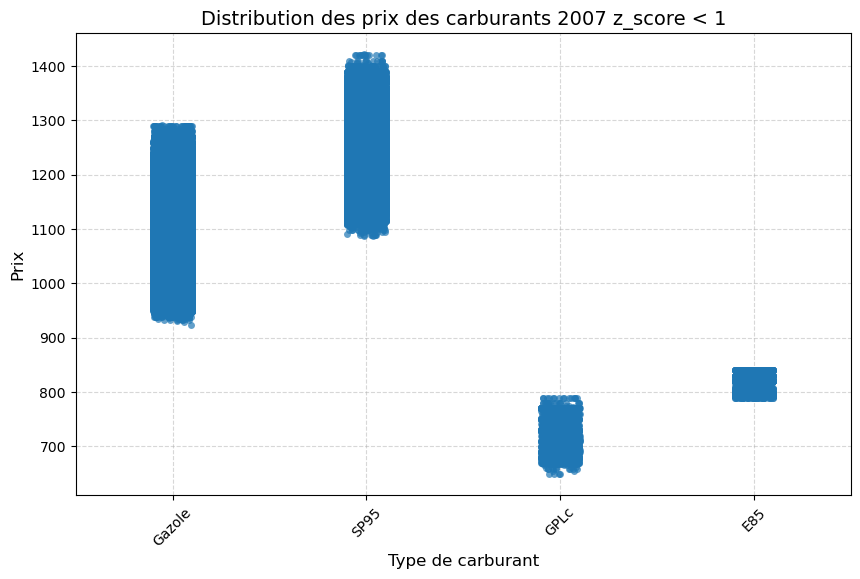

Save to CSV PrixCarburants_annuel_filtered_2007.csv


In [3]:
import pandas as pd
import numpy as np
import os
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore', category=RuntimeWarning)

for i in range(1): # one year only
    year = 2007
# for i in range (19): # all years
#     year = 2007+i
    print("YEAR: ", year)
    file_path = f"results/inputs_csv/PrixCarburants_annuel_{year}.csv"
    
    if not os.path.exists(file_path):
        print(f"Le fichier {file_path} n'existe pas.")
    else:
        df = pd.read_csv(file_path)
        print(df.head(5))

        df_prices = df.copy()
        df_prices['date'] = pd.to_datetime(df_prices['maj'], format='%Y_%m_%d_%H:%M', errors='coerce').dt.strftime('%Y_%m_%d')
        df_prices["date"] = pd.to_datetime(df_prices["date"], format="%Y_%m_%d")
        df_prices['heuremin'] = pd.to_datetime(df_prices['maj'], format='%Y_%m_%d_%H:%M', errors='coerce').dt.strftime('%H:%M')
        df_prices = df_prices.drop(columns=["maj"])
        
        print(df_prices.head(5))
        
        # check outliers min max values for each type carburant
        print(df_prices["nom"].unique())
        list_carburant = df_prices["nom"].dropna().unique()
        for carburant in list_carburant:
            df_carburant = df_prices[df_prices["nom"]== carburant]
            print(f"val MAX {carburant}", df_carburant.nlargest(3, 'valeur')['valeur'].tolist())
            print(f"val MIN {carburant}", df_carburant.nsmallest(3, 'valeur')['valeur'].tolist())

        # clean outlier data by Z-SCORE
        df_prices["z_score"] = df_prices.groupby(["date", "nom"])["valeur"].transform(lambda x: zscore(x, ddof=0))
        df_prices_filtered = df_prices[abs(df_prices["z_score"]) < 1]
        df_prices_filtered = df_prices_filtered.drop(columns=["z_score"])

        ### TRANSFORM VALUES TO KEEP ONLY LAST VALUES OF EACH DAY AFTER Z-SCORE FILTERING
        # df_prices_filtered['heuremin'] = pd.to_datetime(df_prices_filtered['heuremin'], format='%H:%M', errors='coerce').dt.time
        df_prices_filtered['heuremin'] = pd.to_datetime(df_prices_filtered['heuremin'], format='%H:%M', errors='coerce')
        df_prices_filtered = df_prices_filtered.sort_values(by=['id', 'date', 'nom', 'heuremin'])
        df_prices_filtered = df_prices_filtered.groupby(['id', 'date', 'nom'], as_index=False).last()

        print(df_prices_filtered.dtypes)
        
        plt.figure(figsize=(10, 6))
        sns.stripplot(data=df_prices_filtered, x="nom", y="valeur", jitter=True, alpha=0.7)   
        plt.title(f"Distribution des prix des carburants {year} z_score < 1", fontsize=14)
        plt.xlabel("Type de carburant", fontsize=12)
        plt.ylabel("Prix", fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

        df_prices_filtered["date"] = df_prices_filtered["date"].dt.strftime('%Y_%m_%d')
        df_prices_filtered["heuremin"] = df_prices_filtered["heuremin"].dt.strftime('%H:%M')
        
        # rename id to gas_station_id
        df_prices_filtered["gas_station_id"] = df_prices_filtered["id"]
        df_prices_filtered = df_prices_filtered.drop(columns=["id"])
        
        ########### SAVE DF TO CSV ###################
        os.makedirs("results/inputs_csv_zscore_last", exist_ok=True)
        df_prices_filtered.to_csv(f"results/inputs_csv_zscore_last/PrixCarburants_annuel_filtered_{year}.csv", index=False)
        print(f"Save to CSV PrixCarburants_annuel_filtered_{year}.csv")